# Домашнее задание №1. Бусько Полина.

## Меню ноутбука: <a id='menu'></a>

<ul>
    <li><a href='#libs'>Подключение библиотек</a></li>
    <li><a href='#problem'>Постановка задачи</a></li>
    <li><a href='#readdata'>Прочитать данные</a></li>
    <li><a href='#datachar'>Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать</a></li>
    <li><a href='#datanun'>Обработать пропущенные значения</a></li>
    <li><a href='#datacateg'>Обработать категориальные признаки</a></li>
    <li><a href='#norm'>Провести нормализацию</a></li>
    <li><a href='#datatrainrest'>Разбить данные на обучающую и тестовую выборки</a></li>
    <li><a href='#knn'>Запустить классификатор ближайших соседей</a></li>
    <li><a href='#another'>Другие классификаторы</a></li>
    <li><a href='#conclusions'>Выводы</a></li>
</ul>

<a id='libs'></a>(<a href='#menu'>в общее меню</a>)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import nltk
import re
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score,
                             precision_score, recall_score, roc_curve, roc_auc_score, 
                             precision_recall_curve, fbeta_score, auc)
from sklearn.svm import SVC

## 0. Поставновка задачи. <a id='problrm'></a>(<a href='#menu'>в общее меню</a>)

Набор данных представляет собой совокупность медицинских и демографических данных пациента, а также данные о наличии или отсутсвии заболевания диабетом.
Данные включают в себя следующие характеристики: возраст, пол, индекс массы тела (ИМТ), гипертония, болезни сердца, история курения, уровень HbA1c и уровень глюкозы в крови.

Будем решать задачу классификации. Для этого выберем предсказание наличия или отсутствия заболевания диабетом у пациента.

## 1. Прочитать данные. <a id='readdata'></a>(<a href='#menu'>в общее меню</a>)

In [2]:
file_path = 'diabetes_prediction_dataset.csv'
data = pd.read_csv(file_path)

Первые и последние значения из таблицы данных:

In [3]:
data

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [4]:
print("Количество объектов = ", data.shape[0])
print("Количество признаков у каждого объекта: = ", data.shape[1])

Количество объектов =  100000
Количество признаков у каждого объекта: =  9


Выведем информацию о датасете:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Отсюда видно, что имеются следующие признаки:

+ gender - пол
+ age - возраст
+ hypertension - гипертония (наличие/отсутствие)
+ heart_disease - болезнь сердца (наличие/отсутсвие)
+ smoking_history - Курение
+ bmi - Индекс массы тела
+ HbA1c_level - гликированный гемоглобин
+ blood_glucose_level - уровень глюкозы
+ diabetes - Диабет (наличие/отсутвие) - целевая переменная.

Поиск дубликатов:

In [6]:
data.duplicated().sum()

3854

Удаление дубликатов:

In [7]:
data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

Посмотрим на строковые признаки:

In [8]:
data.describe(include= 'object')

,gender,smoking_history
count,96146,96146
unique,3,6
top,Female,never
freq,56161,34398


In [9]:
data['gender'].value_counts()

Female    56161
Male      39967
Other        18
Name: gender, dtype: int64

Признак "Пол", помимо мужского и женского, включает в себя третий - "other", в небольшом количестве (18 шт). Удалим этот признак без риска потери информативности данных.

In [10]:
data = data[data['gender'] != 'Other']

In [11]:
data['smoking_history'].value_counts()

never          34395
No Info        32881
former          9299
current         9197
not current     6359
ever            3997
Name: smoking_history, dtype: int64

Признак 'smoking_history' включает в себя следующие категории:

+ No Info - нет информации
+ never - никогда 
+ former - бывший
+ current - курит в настоящее время
+ not current - не курит в настоящее время (возможно бывший)
+ ever - когда-либо курил

По количество значений видно, что процент людей, про историю курения которых нет информации, примерно равен 35%.  
Проверим это:

In [12]:
print ("% No Info = ", data[data['smoking_history'] == 'No Info'].shape[0] / data.shape[0] *100)

% No Info =  34.2054344207723


Данный признак содержит около 1/3 неинформатиных данных, а другие не полностью логически связанные между собой категории.  
Удалим этот признак:

In [13]:
data = data.drop(columns = ['smoking_history'])

## 2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать <a id='datachar'></a>(<a href='#menu'>в общее меню</a>)

Выведем все диаграммы рассеивания для количественных признаков.

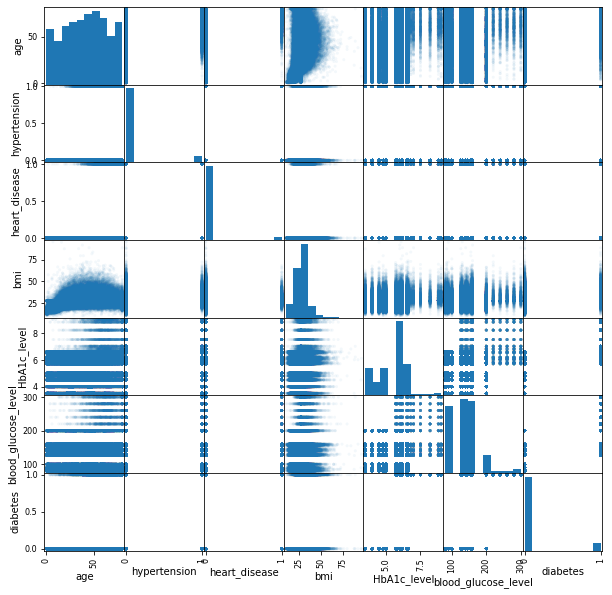

In [14]:
pd.plotting.scatter_matrix(data, figsize = (10, 10), alpha = 0.05)
pass

Визуально видно, что все значения признаков правдоподобны, (экстремально высокие значения ИМТ и уровня глюкозы в крови имеют место быть)

Посчитаем основные статистические характеристики данных по каждому числовому признаку:

In [15]:
data.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000,96128.000000
mean,41.796617,0.077615,0.040810,27.321450,5.532633,138.218001,0.088237
std,22.463329,0.267567,0.197851,6.767811,1.073225,40.911190,0.283640
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


+ mean - среднее значение
+ std - стандартное отклонение
+ min - минимум
+ 25% - нижнее значение первого квантиля
+ 50% - медиана
+ 75% - верхнее значение первого квантиля
+ max - максимум

#### Обработка выбросов

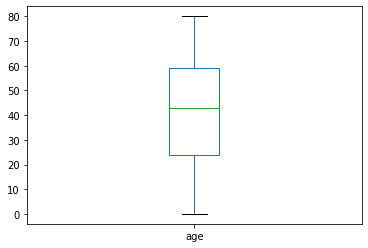

In [16]:
data['age'].plot(kind='box')
pass

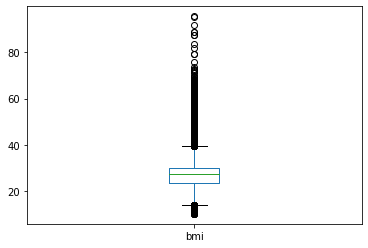

In [17]:
data['bmi'].plot(kind='box')
pass

Посмотрим, на признак ИМТ и выведем пациентов, у которых он выше 60:

In [18]:
data[data['bmi'] >= 60]

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
59,Female,67.0,0,0,63.48,8.8,155,1
562,Male,43.0,0,0,69.37,7.5,130,1
618,Female,59.0,0,1,60.26,8.8,145,1
1395,Female,60.0,1,0,60.20,7.0,200,1
2072,Male,18.0,0,0,65.93,6.0,200,0
...,...,...,...,...,...,...,...,...
96066,Male,80.0,0,0,88.76,6.2,140,0
96673,Female,38.0,0,0,64.26,6.2,100,0
96771,Female,25.0,0,0,64.27,4.5,126,0
97217,Female,71.0,0,0,64.80,9.0,280,1


Таких значений явно немного (относительно общего количества), значит это выбросы - удалим эти строки

In [19]:
data = data[data['bmi'] <= 60]
data.shape

(96013, 8)

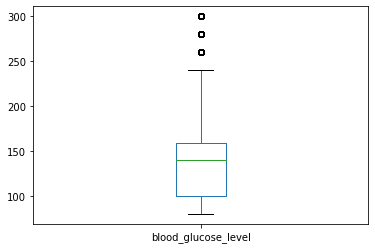

In [20]:
data['blood_glucose_level'].plot(kind='box')
pass

Теперь посмотрим на признак уровня глюкозы в крови и выведем пациентов, у которых он выше 250:

In [21]:
data[data['blood_glucose_level'] >= 250]

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
38,Male,50.0,1,0,27.32,5.7,260,1
94,Female,60.0,0,0,27.32,7.5,300,1
104,Female,80.0,1,0,27.32,6.8,280,1
125,Female,77.0,0,0,31.70,6.5,280,1
142,Female,80.0,0,0,21.97,7.0,300,1
...,...,...,...,...,...,...,...,...
99763,Female,50.0,0,0,35.91,6.0,280,1
99826,Male,63.0,0,1,27.32,6.6,300,1
99867,Male,64.0,1,0,33.12,5.7,300,1
99938,Male,55.0,0,1,30.42,6.2,300,1


У всех пациентов есть диабет, возраст преимущественно старше 50 лет. Не будем считать данные значения выбросами.

Можно вычислить матрицу корреляции для количественных признаков:

In [22]:
corr_mat = data.corr()
corr_mat

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
age,1.000000,0.257393,0.238527,0.351708,0.106437,0.114205,0.264923
hypertension,0.257393,1.000000,0.120049,0.149077,0.081188,0.084549,0.195523
heart_disease,0.238527,0.120049,1.000000,0.062216,0.067819,0.070754,0.170774
bmi,0.351708,0.149077,0.062216,1.000000,0.083280,0.091813,0.214218
HbA1c_level,0.106437,0.081188,0.067819,0.083280,1.000000,0.171101,0.405739
blood_glucose_level,0.114205,0.084549,0.070754,0.091813,0.171101,1.000000,0.423810
diabetes,0.264923,0.195523,0.170774,0.214218,0.405739,0.423810,1.000000


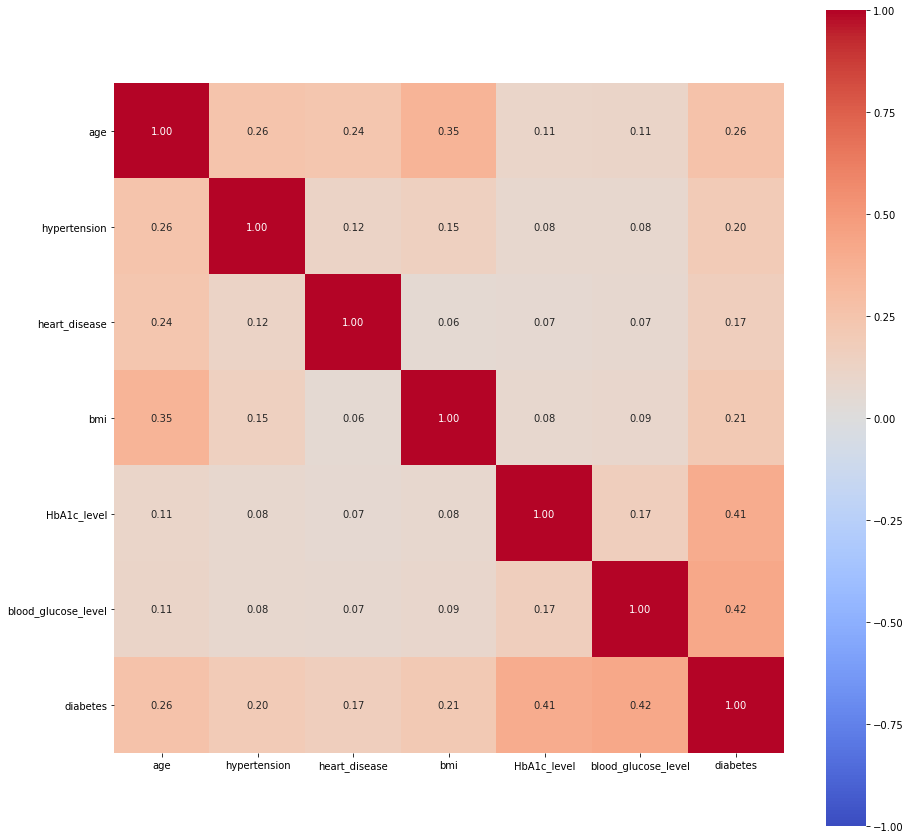

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f', vmin=-1, vmax=1, cmap='coolwarm')
pass

Вывод: есть корреляция между `'age'` и `'bmi'`, `'blood_glucose_level'` и `'diabetes'`, `'HbA1c_level'` и `'diabetes'`

Доля пациентов с диабетом

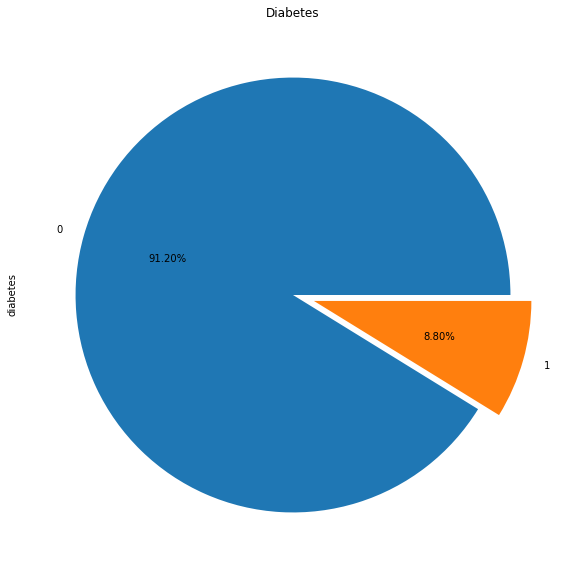

In [24]:
data.diabetes.value_counts().plot(kind = 'pie', figsize=(10,10), autopct = '%1.2f%%',explode = [0, 0.1])
plt.title('Diabetes')
plt.show()

Доля пациентов с диабетом 8,8% (классы не сбалансированы)

## 3. Обработать пропущенные значения <a id='datanun'></a>(<a href='#menu'>в общее меню</a>)

In [25]:
missing_values = data.isnull().sum()
print("Пропущенные значения в каждом столбце:")
print(missing_values)

all_missing = missing_values.sum()
print(f"\nОбщее количество пропуcков: {all_missing}")

Пропущенные значения в каждом столбце:
gender                 0
age                    0
hypertension           0
heart_disease          0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Общее количество пропуcков: 0


## 4. Обработать категориальные признаки <a id='datacateg'></a>(<a href='#menu'>в общее меню</a>)

In [26]:
data_encoded = data.copy()

In [27]:
labelencoder = LabelEncoder()
 
data_encoded['gender'] = labelencoder.fit_transform(data_encoded['gender'])

In [28]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96013 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               96013 non-null  int32  
 1   age                  96013 non-null  float64
 2   hypertension         96013 non-null  int64  
 3   heart_disease        96013 non-null  int64  
 4   bmi                  96013 non-null  float64
 5   HbA1c_level          96013 non-null  float64
 6   blood_glucose_level  96013 non-null  int64  
 7   diabetes             96013 non-null  int64  
dtypes: float64(3), int32(1), int64(4)
memory usage: 6.2 MB


## 5. Провести нормализацию <a id='norm'></a>(<a href='#menu'>в общее меню</a>)

In [29]:
columns = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
scaler = preprocessing.RobustScaler()
data_encoded[columns] = scaler.fit_transform(data_encoded[columns])
data_encoded

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1.057143,0,1,-0.331260,0.571429,0.000000,0
1,0,0.314286,0,0,0.000000,0.571429,-1.016949,0
2,1,-0.428571,0,0,0.000000,-0.071429,0.305085,0
3,0,-0.200000,0,0,-0.601866,-0.571429,0.254237,0
4,1,0.942857,1,1,-1.116641,-0.714286,0.254237,0
...,...,...,...,...,...,...,...,...
99994,0,-0.200000,0,0,-0.423017,-0.714286,0.084746,0
99996,0,-1.171429,0,0,-1.547434,0.500000,-0.677966,0
99997,1,0.657143,0,0,0.079316,-0.071429,0.254237,0
99998,0,-0.542857,0,0,1.259720,-1.285714,-0.677966,0


## 6. Разбить данные на обучающую и тестовую выборки <a id='datatrainrest'></a>(<a href='#menu'>в общее меню</a>)

Разобьем данные на обучающую и тестовую выборки следующим образом: 80% - обучающая выборка, 20% - тестовая.

In [30]:
X = data_encoded.drop('diabetes', axis = 1)
y = data_encoded.diabetes

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size = 0.2, random_state = 42)
N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test

(76810, 19203)

In [31]:
y_test.value_counts()

0    17514
1     1689
Name: diabetes, dtype: int64

In [32]:
y_train.value_counts()

0    70054
1     6756
Name: diabetes, dtype: int64

классы не сбалансированы

In [33]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76810 entries, 1713 to 12128
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               76810 non-null  int32  
 1   age                  76810 non-null  float64
 2   hypertension         76810 non-null  int64  
 3   heart_disease        76810 non-null  int64  
 4   bmi                  76810 non-null  float64
 5   HbA1c_level          76810 non-null  float64
 6   blood_glucose_level  76810 non-null  float64
dtypes: float64(4), int32(1), int64(2)
memory usage: 4.4 MB


Боремся с дисбалансом классов

In [34]:
smote = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train_resampled, y_train_resampled =smote.fit_resample(X_train, y_train)

In [35]:
y_train_resampled.value_counts()

0    70054
1    70054
Name: diabetes, dtype: int64

## 7. Запустить классификатор ближайших соседей <a id='knn'></a>(<a href='#menu'>в общее меню</a>)

In [36]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     17514
           1       0.74      0.69      0.71      1689

    accuracy                           0.95     19203
   macro avg       0.85      0.83      0.84     19203
weighted avg       0.95      0.95      0.95     19203



#### Подбор оптимального количества ближайших соседей

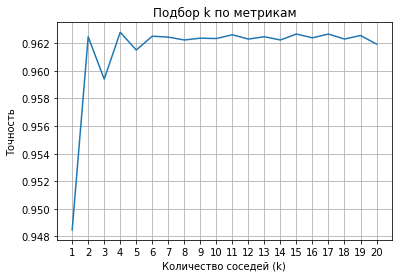

Оптимальное значение k: 4


In [38]:
k_values = range(1, 21)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    accuracies.append(scores.mean())

plt.plot(k_values, accuracies)
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.title('Подбор k по метрикам')
plt.xticks(k_values)
plt.grid()
plt.show()

optimal_k = k_values[np.argmax(accuracies)]
print(f'Оптимальное значение k: {optimal_k}')

In [39]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17514
           1       0.95      0.62      0.75      1689

    accuracy                           0.96     19203
   macro avg       0.96      0.81      0.86     19203
weighted avg       0.96      0.96      0.96     19203



Ошибка на обучающей и тестовой выборках:

In [41]:
knn = KNeighborsClassifier(n_neighbors = optimal_k).fit(X_train, y_train)

err_train = np.mean(y_train != knn.predict(X_train))
err_test  = np.mean(y_test  != knn.predict(X_test))

print(err_train, err_test)

0.03024345788308814 0.03676508878821017


## 8. Другие классификаторы <a id='another'></a>(<a href='#menu'>в общее меню</a>)

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#### RandomForestClassifier

In [43]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [44]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17514
           1       0.93      0.70      0.80      1689

    accuracy                           0.97     19203
   macro avg       0.95      0.85      0.89     19203
weighted avg       0.97      0.97      0.97     19203



Попробуем максимизировать метрику recall путем подбора гиперпараметров:

In [45]:
n_estimators_values = range(1, 101)

best_recall = 0
best_n_estimators = 1

for n_estimators in n_estimators_values:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    current_recall = recall_score(y_test, y_pred)
    if current_recall > best_recall:
        best_recall = current_recall
        best_n_estimators = n_estimators

print("Лучший n_estimators:", best_n_estimators)
print("Лучший recall на тестовой выборке:", best_recall)

Лучший n_estimators: 1
Лучший recall на тестовой выборке: 0.7335701598579041


In [46]:
clf = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
optimal_recall = recall_score(y_test, y_pred)

print("Recall на тестовой выборке с оптимальным n_estimators:", optimal_recall)

Recall на тестовой выборке с оптимальным n_estimators: 0.7335701598579041


In [47]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     17514
           1       0.72      0.73      0.73      1689

    accuracy                           0.95     19203
   macro avg       0.85      0.85      0.85     19203
weighted avg       0.95      0.95      0.95     19203



После подбора гиперпараметра, видим, что значение recall немногоулучшилось. Но значение precision немного снизилось. Так как данная задача медицинского характера, то отдадим препочтение метрике recall.

#### LogisticRegression

In [48]:
clf = LogisticRegression(random_state = 42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17514
           1       0.86      0.62      0.72      1689

    accuracy                           0.96     19203
   macro avg       0.91      0.81      0.85     19203
weighted avg       0.96      0.96      0.95     19203



Попробуем максимизировать метрику recall путем подбора гиперпараметров:

In [50]:
C_values = np.logspace(-4, 4, 10)
penalties = ['l1', 'l2']

best_recall = 0
optimal_params = {}

for penalty in penalties:
    for C in C_values:
        model = LogisticRegression(random_state = 42, C=C, penalty=penalty, solver='liblinear')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        current_recall = recall_score(y_test, y_pred)
        if current_recall > best_recall:
            best_recall = current_recall
            optimal_params = {'C': C, 'penalty': penalty}

print("Лучшие параметры:", optimal_params)
print("Лучший recall на тестовой выборке:", best_recall)

Лучшие параметры: {'C': 0.3593813663804626, 'penalty': 'l1'}
Лучший recall на тестовой выборке: 0.6246299585553582


In [52]:
clf = LogisticRegression(random_state=42, C=optimal_params['C'], penalty=optimal_params['penalty'], solver='liblinear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
optimal_recall = recall_score(y_test, y_pred)

print("Recall на тестовой выборке с оптимальными параметрами:", optimal_recall)

Recall на тестовой выборке с оптимальными параметрами: 0.6246299585553582


In [53]:
print(classification_report(y_test, y_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17514
           1       0.86      0.62      0.72      1689

    accuracy                           0.96     19203
   macro avg       0.91      0.81      0.85     19203
weighted avg       0.96      0.96      0.95     19203



Из значений метрик, полученных, после обучения модели с параметрами, подобранными таким образом, чтобы максимизировалась метрика recall, видим, что значение метрики не изменилось. Подбор параметра не улучшил результат.

Построим матрицу рассогласования:

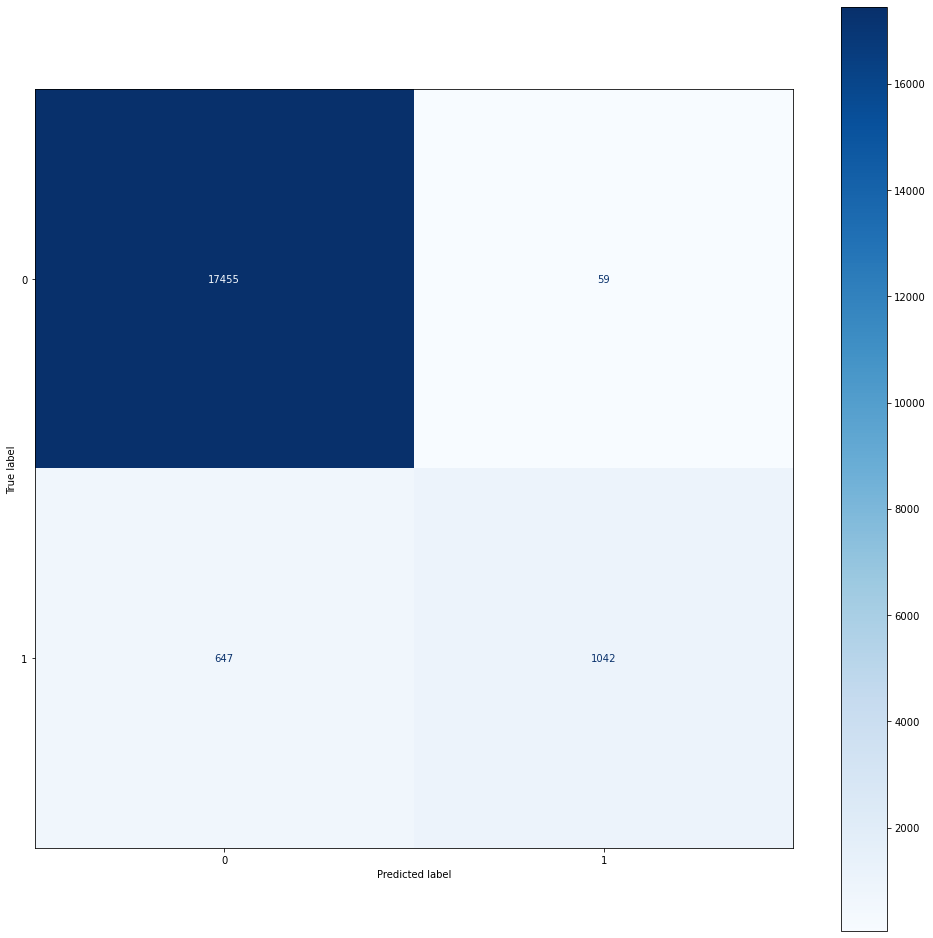

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay
fig = plt.figure(figsize=(17, 17))
ax = fig.add_subplot(1,1,1)
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
pass

## 9. Выводы <a id='conclusions'></a>(<a href='#menu'>в общее меню</a>)

#### kNN
+ accuracy: около 0.96, но ошибка на тестовых данных выше, чем на обучении. Это указывает на небольшое переобучение.
+ F1-score: для класса 0 выше, чем для 1 (дисбаланс данных).
+ Precision и Recall: высокая точность для 0 (0.96-1.0) и сравнительно низкая для 1 (0.75-0.80), из-за чего могут быть проблемы с обнаружением класса 0.

#### Random Forest
+ Accuracy: самая высокая среди моделей. 
+ F1-score: Хорошо сбалансирован между классами.
+ Precision и Recall: Высокие значения для обоих классов, это говорит об устойчивости модели даже при дисбалансе данных. 

Подбор гиперпараметра для данной модели позволил улучшить результат (увеличит значение recall)

#### Logistic Regression
+ Accuracy: ниже, чем у остальных моделей.
+ F1-score: Для класса 1 значительно ниже, что делает её менее подходящей.
+ Precision и Recall: Низкий Recall для класса 1, это говорит о большом числе ложных отрицаний

##### Random Forest показал наилучший результат по всем ключевым метрикам и устойчивость к дисбалансу.